# CHRR implementation

### Numba

In [8]:
import numpy as np
import time
from numba import njit, float64, int64, boolean

# --- Shared Numba Logic ---

@njit(cache=True)
def gcd_recursive(a, b):
    while b:
        a, b = b, a % b
    return a

@njit(cache=True)
def get_gcd_of_array(arr):
    """Calculates GCD of a vector. Returns 1 immediately if any pair gives 1."""
    d = len(arr)
    if d == 0: return 0
    result = abs(arr[0])
    for i in range(1, d):
        result = gcd_recursive(result, abs(arr[i]))
        if result == 1:
            return 1
    return result

@njit(cache=True)
def is_valid_integer_point(point, A, b, R_sq):
    """
    Checks 3 conditions:
    1. Inside Radius (L2)
    2. Inside Cone (Ax <= b)
    3. GCD == 1
    """
    # 1. Radius Check
    norm_sq = 0.0
    for x in point:
        norm_sq += x*x
    if norm_sq > R_sq or norm_sq == 0: # Exclude origin
        return False

    # 2. Cone Check (Ax <= b)
    # Manual dot product for speed
    m, d = A.shape
    for i in range(m):
        dot = 0.0
        for j in range(d):
            dot += A[i, j] * point[j]
        if dot < b[i]:
            return False

    # 3. GCD Check (Primitive)
    if get_gcd_of_array(point) != 1:
        return False

    return True

### Implement

In [9]:
import numpy as np
import time
from numba import njit, float64, int64, boolean

@njit(cache=True)
def get_chrr_limits(idx, x, A_cols, b, current_Ax, R_sq):
    """
    Computes the valid range [t_min, t_max] for moving along axis 'idx'
    such that x + t*e_idx stays inside Ax<=b AND ||x|| <= R
    """
    t_min = -1e20 # arbitrary large
    t_max = 1e20

    # --- 1. Cone Constraints (Ax <= b) ---
    # Condition: A_row * (x + t*e_i) <= b_row
    #            (A_row*x) + t*A_row[i] <= b_row
    #            t * A_col_i[row] <= b_row - current_Ax[row]

    # We iterate over the pre-transposed A (A_cols) for cache efficiency
    col_data = A_cols[idx]
    m = len(b)

    for row in range(m):
        slope = col_data[row]
        # rem = b[row] - current_Ax[row] (but slightly safer to recompute if accumulating error?)
        # For CHRR speed, we usually use the tracked Ax.
        rem = b[row] - current_Ax[row]

        if slope > 1e-9:
            # t <= rem / slope
            t_max = min(t_max, rem / slope)
        elif slope < -1e-9:
            # t * neg <= rem  ->  t >= rem / neg
            t_min = max(t_min, rem / slope)
        else:
            # slope is 0. If constraint violated, line is invalid entirely.
            if rem < 0:
                return 1.0, -1.0 # Return empty interval

    # --- 2. Ball Constraint (||x + t*e_i||^2 <= R^2) ---
    # sum(x_j^2) - x_i^2 + (x_i + t)^2 <= R^2
    # (x_i + t)^2 <= R^2 - (current_norm_sq - x_i^2)

    current_norm_sq = 0.0
    for val in x:
        current_norm_sq += val*val

    rem_rad_sq = R_sq - (current_norm_sq - x[idx]**2)

    if rem_rad_sq < 0:
        return 1.0, -1.0 # Invalid

    limit_r = np.sqrt(rem_rad_sq)
    # -limit_r <= x_i + t <= limit_r
    # t >= -limit_r - x_i
    # t <= limit_r - x_i

    t_min = max(t_min, -limit_r - x[idx])
    t_max = min(t_max, limit_r - x[idx])

    return t_min, t_max

@njit(cache=True)
def chrr_walker(A, A_cols, b, R_sq, start_point, n_desired, thinning, buf_out):
    """
    A: (m, d)
    A_cols: (d, m) - Transposed A for fast column access
    """
    m, d = A.shape

    # Current State
    x = start_point.copy()
    current_Ax = np.dot(A, x)

    found = 0
    steps = 0

    # Temp buffer for integer check
    temp_int = np.zeros(d, dtype=np.int64)

    while found < n_desired:
        # 1. Coordinate Hit-and-Run Step
        # Pick random axis
        axis_idx = np.random.randint(0, d)

        # Get valid line segment
        t_min, t_max = get_chrr_limits(axis_idx, x, A_cols, b, current_Ax, R_sq)

        if t_max >= t_min:
            # Move to random point in interval
            t = np.random.uniform(t_min, t_max)

            # Update State
            x[axis_idx] += t
            # Update Ax efficiently: Ax_new = Ax_old + t * A_col_i
            # This is O(m)
            for row in range(m):
                current_Ax[row] += t * A_cols[axis_idx, row]

        steps += 1

        # 2. Harvesting (Thinning)
        # We only try to harvest every 'thinning' steps to ensure mixing
        if steps % thinning == 0:
            # Try to extract an integer point
            # Technique: Take continuous x, add Uniform(-0.5, 0.5), Round.
            # Then CHECK constraints.

            valid_harvest = True
            norm_sq = 0.0

            for k in range(d):
                # Add jitter + Round
                val = x[k] + np.random.uniform(-0.5, 0.5)
                ival = int(round(val))
                temp_int[k] = ival
                norm_sq += ival*ival

            # Check Radius
            if norm_sq > R_sq or norm_sq == 0:
                valid_harvest = False

            # Check Cone (Must re-check because rounding might push us out)
            if valid_harvest:
                for row in range(m):
                    dot = 0.0
                    for col in range(d):
                        dot += A[row, col] * temp_int[col]
                    if dot > b[row]:
                        valid_harvest = False
                        break

            # Check GCD
            if valid_harvest:
                if get_gcd_of_array(temp_int) != 1:
                    valid_harvest = False

            if valid_harvest:
                # Store
                buf_out[found, :] = temp_int[:]
                found += 1

    return steps

class CHRRSampler:
    def __init__(self, A, b, R, thinning=3):
        self.A = np.ascontiguousarray(A, dtype=np.float64)
        # We pre-transpose A for faster column access in the walker
        self.A_cols = np.ascontiguousarray(A.T, dtype=np.float64)
        self.b = np.ascontiguousarray(b, dtype=np.float64)
        self.R = float(R)
        self.R_sq = self.R**2
        self.thinning = thinning

    def find_start_point(self):
        """Finds a valid continuous point inside to start the chain."""
        # Simple Rejection Sampling Attempt (usually finds one instantly)
        # If the cone is SO thin this fails, we need LP, but let's assume this works.
        d = self.A.shape[1]
        for _ in range(10000):
            # Sample in small box around origin or uniform in R
            cand = np.random.uniform(-self.R/10, self.R/10, size=d)
            if np.linalg.norm(cand) > self.R: continue
            if np.all(self.A @ cand <= self.b):
                return cand
        raise RuntimeError("Could not find starting point for CHRR. Cone is too thin or closed.")

    def sample(self, n_samples):
        t0 = time.time()
        start_pt = self.find_start_point()

        # Buffer for Numba
        buf = np.zeros((n_samples, self.A.shape[1]), dtype=np.int64)

        # Run Walker
        # Note: CHRR naturally produces duplicates if the chain stays in the same
        # "integer cell" for multiple harvest steps.
        chrr_walker(self.A, self.A_cols, self.b, self.R_sq, start_pt, n_samples, self.thinning, buf)

        # Post-process for global Uniqueness
        # Because CHRR is a chain, we might need to run longer to get *unique* points
        # So we filter here.
        # unique_set = set(tuple(x) for x in buf)
        unique_set = list(tuple(x) for x in buf)

        # Convert back to array
        final_arr = np.array(list(unique_set))
        return final_arr, time.time() - t0

### Verification

In [10]:
import numpy as np
import matplotlib.pyplot as plt

def verify_samples(points, A, b, R):
    """
    points: (N, d) integer array
    A, b: Cone constraints
    R: Radius
    """
    print(f"--- Verifying {len(points)} Points ---")
    points = points.astype(np.int64)
    N, d = points.shape

    # -----------------------------
    # 1. Strict Constraint Checks
    # -----------------------------

    # A. GCD Check
    # np.gcd.reduce computes the GCD over an axis
    # We take absolute values because GCD is defined on positives
    gcds = np.gcd.reduce(np.abs(points), axis=1)
    n_gcd_fail = np.sum(gcds != 1)

    # B. Radius Check
    norms = np.linalg.norm(points, axis=1)
    n_rad_fail = np.sum(norms > R + 1e-9) # small float tol

    # C. Cone Check (Ax <= b)
    # We do a bulk dot product: (N, d) @ (d, m) -> (N, m)
    # Note: A is (m, d), so we transpose A
    projections = points @ A.T
    # Check if any constraint is violated for each point
    # violation_mask is (N,) boolean
    violation_mask = np.any(projections > b + 1e-9, axis=1)
    n_cone_fail = np.sum(violation_mask)

    # D. Duplicates Check
    # Convert to void view to use np.unique on rows efficiently
    # or just use python set for simplicity
    unique_count = len(set(tuple(p) for p in points))
    n_dupes = N - unique_count

    print(f"1. GCD != 1 Failures:   {n_gcd_fail}  ({(n_gcd_fail/N)*100:.2f}%)")
    print(f"2. Radius Failures:     {n_rad_fail}  ({(n_rad_fail/N)*100:.2f}%)")
    print(f"3. Cone Failures:       {n_cone_fail}  ({(n_cone_fail/N)*100:.2f}%)")
    print(f"4. Duplicates:          {n_dupes}  ({(n_dupes/N)*100:.2f}%)")

    success = (n_gcd_fail == 0) and (n_rad_fail == 0) and (n_cone_fail == 0)
    if success:
        print("\n✅ PASSED STRICT CHECKS")
    else:
        print("\n❌ FAILED STRICT CHECKS")

    # -----------------------------
    # 2. Uniformity Visualizations
    # -----------------------------
    fig, ax = plt.subplots(1, 2, figsize=(12, 5))

    # Visual 1: 2D Projection (First 2 Dimensions)
    # This helps see if the "Cone" shape is visible
    ax[0].scatter(points[:, 0], points[:, 1], s=1, alpha=0.5)
    ax[0].set_title(f"Projection on Dim 0 vs Dim 1\n(Should look like 2D slice of cone)")
    ax[0].set_xlabel("Dim 0")
    ax[0].set_ylabel("Dim 1")
    ax[0].axis('equal')

    # Visual 2: Radial Distribution (The "Are we uniform?" Test)
    # Theory: For uniform points in a D-dim ball, the CDF of radius r is (r/R)^D
    # If we plot Sorted( (r/R)^D ), it should differ very little from the diagonal line y=x.

    # Normalize radii
    r_normalized = norms / R
    # Ideally, points should not exceed R, but if slight rounding error, clip at 1.0
    r_normalized = np.clip(r_normalized, 0, 1)

    # Transform: u = (r/R)^d. If uniform, u is Uniform(0,1)
    u_values = np.power(r_normalized, d)

    # Sort to get empirical CDF
    y_empirical = np.sort(u_values)
    x_theoretical = np.linspace(0, 1, len(y_empirical))

    ax[1].plot(x_theoretical, y_empirical, label='Empirical', lw=2)
    ax[1].plot([0, 1], [0, 1], 'r--', label='Ideal Uniform', lw=1)
    ax[1].set_title(f"Radial Uniformity Check (d={d})\n(Curves should match)")
    ax[1].set_xlabel("Theoretical Quantile")
    ax[1].set_ylabel("Empirical Quantile")
    ax[1].legend()

    plt.tight_layout()
    plt.show()

# --- Example Usage ---
# Assuming 'points_sampled' comes from your sampler, and A, b, R are defined
# verify_samples(points_sampled, A, b, R)

### RUN

In [11]:
# --- Usage Example ---

# 1. Define Geometry (Example: 5D cone)
d = 11
m = 10
# np.random.seed(42)
A =  np.eye(d) # np.random.randn(m, d)
# Ensure 0 is inside (b > 0)
# b = np.abs(np.random.randn(m))
b = np.zeros(d)
R = 5.0

# 2. Try Layered First
print("Running Layered Sampler...")
# sampler1 = LayeredSampler(A, b, R)
# points_layered, t1 = sampler1.sample(5000)
# print(f"Layered: Found {len(points_layered)} unique points in {t1:.4f}s")

# 3. If Layered is too slow, use CHRR
print("\nRunning CHRR Sampler...")
sampler2 = CHRRSampler(A, b, R, thinning=5) # Increase thinning if correlation is high
points_chrr, t2 = sampler2.sample(5000)
# points_chrr = [sampler2.sample(10)[0] for _ in range(100)]
# points_chrr = np.array([s for l in points_chrr for s in l])
print(f"CHRR: Found {len(points_chrr)} unique points in {t2:.4f}s")

Running Layered Sampler...

Running CHRR Sampler...
CHRR: Found 5000 unique points in 0.0464s


--- Verifying 5000 Points ---
1. GCD != 1 Failures:   0  (0.00%)
2. Radius Failures:     0  (0.00%)
3. Cone Failures:       0  (0.00%)
4. Duplicates:          60  (1.20%)

✅ PASSED STRICT CHECKS


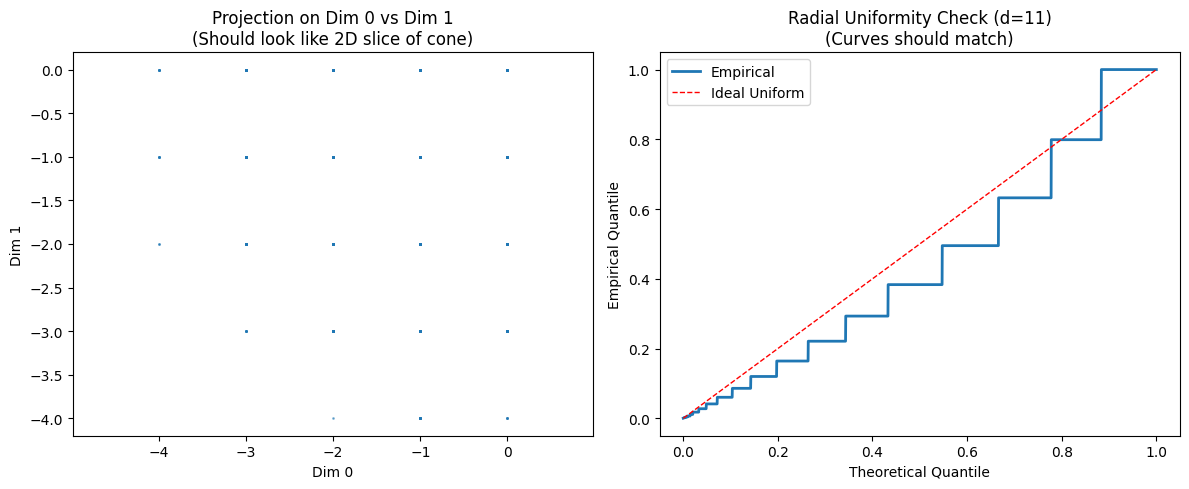

In [12]:
verify_samples(points_chrr, A, b, R)

In [13]:
import numpy as np
from math import gcd
from collections import Counter
from scipy.stats import kstest


# ---------------------------------------------------
# Helper functions
# ---------------------------------------------------

def gcd_vec(v):
    g = 0
    for x in v:
        g = gcd(g, abs(int(x)))
    return g


def remove_zero_vectors(points):
    pts = np.asarray(points, dtype=int)
    nonzero_mask = np.any(pts != 0, axis=1)
    removed = pts.shape[0] - np.sum(nonzero_mask)
    return pts[nonzero_mask], removed


def normalize_rows(X):
    norms = np.linalg.norm(X, axis=1)
    return X / norms[:, None], norms


# ---------------------------------------------------
# Main validation
# ---------------------------------------------------

def validate_samples(points, num_bins=30):
    pts = np.asarray(points, dtype=int)
    N, d = pts.shape

    # ---- 1. Zero vectors ----
    pts, zero_removed = remove_zero_vectors(pts)

    # ---- 2. Duplicates ----
    unique = np.unique(pts, axis=0)
    duplicate_count = pts.shape[0] - unique.shape[0]
    duplicate_rate = duplicate_count / pts.shape[0]

    # ---- 3. gcd = 1 ----
    gcd_fail_mask = np.array([gcd_vec(p) != 1 for p in pts])
    gcd_fail_count = np.sum(gcd_fail_mask)

    # ---- 4. Radius / layer information ----
    _, radii = normalize_rows(pts)
    layer_counts = Counter(radii.astype(int))  # integer shell approx

    # per-layer duplicate rate
    dup_by_layer = {}
    for r in set(radii.astype(int)):
        pts_r = pts[radii.astype(int) == r]
        uniq_r = np.unique(pts_r, axis=0)
        dup_by_layer[int(r)] = 1 - (len(uniq_r) / len(pts_r))

    # ---- 5. Angular diagnostics ----
    dirs, r = normalize_rows(pts)

    # 5a. Dot product of consecutive directions
    dot = np.sum(dirs[:-1] * dirs[1:], axis=1)

    # Hist + χ² test
    hist, _ = np.histogram(dot, bins=num_bins, range=(-1, 1))
    expected = np.full_like(hist, hist.mean())
    chi2 = np.sum((hist - expected)**2 / expected)

    # 5b. Kolmogorov–Smirnov test
    # For a uniform sphere, dot products are ~ Uniform(-1,1)
    ks_stat, ks_p = kstest(dot, 'uniform', args=(-1, 2))  # U(-1,1) has range 2

    # 5c. Pairwise angle distribution (random subset)
    M = min(3000, len(dirs))
    idx = np.random.choice(len(dirs), size=M, replace=False)
    sample_dirs = dirs[idx]

    # pairwise dot products
    pdot = sample_dirs @ sample_dirs.T
    pdot = pdot[np.triu_indices(M, k=1)]  # upper triangle

    hist_pair, _ = np.histogram(pdot, bins=num_bins, range=(-1, 1))
    expected_pair = np.full_like(hist_pair, hist_pair.mean())
    chi2_pair = np.sum((hist_pair - expected_pair)**2 / expected_pair)

    # 5d. Nearest-neighbor angular spacing test
    # Compute angle = arccos(dot)
    # For high dimensions, nearest-neighbor angles concentrate.
    # We measure spread.
    angles = np.arccos(np.clip(pdot, -1, 1))
    nn_var = np.var(angles)

    # ---------------------------------------------------
    # Final result dictionary
    # ---------------------------------------------------

    return {
        "N_input": N,
        "zero_vectors_removed": zero_removed,

        "unique_points": unique.shape[0],
        "duplicates": duplicate_count,
        "duplicate_rate": duplicate_rate,

        "gcd_failures": gcd_fail_count,
        "gcd_ok": gcd_fail_count == 0,

        "radius_mean": float(np.mean(radii)),
        "radius_std": float(np.std(radii)),

        "layer_counts": dict(layer_counts),
        "duplicates_by_layer": dup_by_layer,

        # Angular tests
        "angular_chi2": float(chi2),
        "angular_KS_stat": float(ks_stat),
        "angular_KS_pvalue": float(ks_p),

        "pairwise_chi2": float(chi2_pair),
        "nn_angle_variance": float(nn_var),
    }


# ---------------------------------------------------
# Pretty-print summary
# ---------------------------------------------------

def print_validation(stats):
    print("===== Validation Report =====")
    print(f"Total samples input:         {stats['N_input']}")
    print(f"Zero vectors removed:        {stats['zero_vectors_removed']}")
    print(f"Unique points:               {stats['unique_points']}")
    print(f"Duplicates:                  {stats['duplicates']}")
    print(f"Duplicate rate:              {stats['duplicate_rate']:.4f}")
    print(f"gcd failures:                {stats['gcd_failures']} (ok={stats['gcd_ok']})")
    print()
    print("Radius stats:")
    print(f"  mean radius:               {stats['radius_mean']:.4f}")
    print(f"  std radius:                {stats['radius_std']:.4f}")
    print()
    print("Angular uniformity:")
    print(f"  χ² (consecutive dirs):     {stats['angular_chi2']:.3f}")
    print(f"  KS stat:                   {stats['angular_KS_stat']:.3f}")
    print(f"  KS p-value:                {stats['angular_KS_pvalue']:.3f}")
    print(f"  Pairwise χ²:               {stats['pairwise_chi2']:.3f}")
    print(f"  NN angle variance:         {stats['nn_angle_variance']:.6f}")
    print()
    print("Duplicates by layer (integer radius):")
    for r, v in sorted(stats["duplicates_by_layer"].items()):
        print(f"  r={r}: {v:.3f}")


In [14]:

# points_chrr, filtered = filter_zero_points(points_chrr)# samples: (N, d) numpy array from your sampler
# print(filtered)
res = validate_samples(points_chrr)
print_validation(res)
# from pprint import pprint
# pprint(res)
# print("chi2 p-value (higher is better):", res['chi2_p_value'])
# print("duplicates:", res['duplicates'], "dup_rate:", res['dup_rate'])
# print("gcd=1 fraction:", res['gcd1_fraction'])


===== Validation Report =====
Total samples input:         5000
Zero vectors removed:        0
Unique points:               4940
Duplicates:                  60
Duplicate rate:              0.0120
gcd failures:                0 (ok=True)

Radius stats:
  mean radius:               4.5010
  std radius:                0.4229

Angular uniformity:
  χ² (consecutive dirs):     22662.904
  KS stat:                   0.737
  KS p-value:                0.000
  Pairwise χ²:               12488698.003
  NN angle variance:         0.036330

Duplicates by layer (integer radius):
  r=2: 0.000
  r=3: 0.008
  r=4: 0.012
  r=5: 0.019


In [15]:
import numpy as np
from scipy.special import gamma, zeta

def compute_required_radius(A, n_target, sample_count=10000, safety_factor=1.05):
    """
    Estimates the Radius R needed to get n_target integer points
    with GCD=1 inside the cone Ax <= 0.
    """
    m, d = A.shape

    # 1. Estimate Fraction of Sphere Covered by Cone (Monte Carlo)
    # We ignore 'b' here and use b=0 because for large R,
    # the volume is dominated by the angular opening (Ax <= 0).

    # Generate random directions on unit sphere
    raw = np.random.normal(size=(sample_count, d))
    norms = np.linalg.norm(raw, axis=1, keepdims=True)
    dirs = raw / norms

    # Check how many satisfy Ax <= 0
    # A: (m, d), dirs: (N, d) -> (N, m)
    projections = dirs @ A.T

    # Check if all constraints <= 0 for each direction
    inside_mask = np.all(projections <= 1e-9, axis=1)
    fraction = np.sum(inside_mask) / sample_count

    if fraction == 0:
        raise ValueError("Cone is too thin! Monte Carlo found 0 hits. "
                         "Cannot estimate R. You might need to pick R manually or increase sample_count.")

    print(f"Estimated Cone Fraction: {fraction:.4%}")

    # 2. Volume of Unit Ball in d-dimensions
    # V_unit = pi^(d/2) / gamma(d/2 + 1)
    vol_unit_ball = (np.pi ** (d / 2.0)) / gamma(d / 2.0 + 1.0)

    # 3. Density of Primitive Vectors (GCD=1)
    # Density approx 1/zeta(d)
    # For d=1, density is technically 0 in limit, but practical for geometry.
    prim_density = 1.0 / zeta(d) if d > 1 else 1.0

    # 4. Solve for R
    # N = Vol_Unit * R^d * Fraction * Density
    # R^d = N / (Vol_Unit * Fraction * Density)

    term = n_target / (vol_unit_ball * fraction * prim_density)
    R_est = term ** (1.0 / d)

    # Apply safety factor
    R_final = R_est * safety_factor

    return R_final, fraction * 100

# --- Usage Example ---
# A = np.random.randn(10, 5) # Your A matrix
# N = 100000
# R_needed = compute_required_radius(A, N)
# print(f"Suggested Radius: {R_needed:.4f}")

In [16]:
N = 1e6
R, fraction = compute_required_radius(A, N , safety_factor=1)
R

Estimated Cone Fraction: 0.0500%


np.float64(6.6154311908712335)

--- Verifying 52500 Points ---
1. GCD != 1 Failures:   0  (0.00%)
2. Radius Failures:     0  (0.00%)
3. Cone Failures:       0  (0.00%)
4. Duplicates:          492  (0.94%)

✅ PASSED STRICT CHECKS


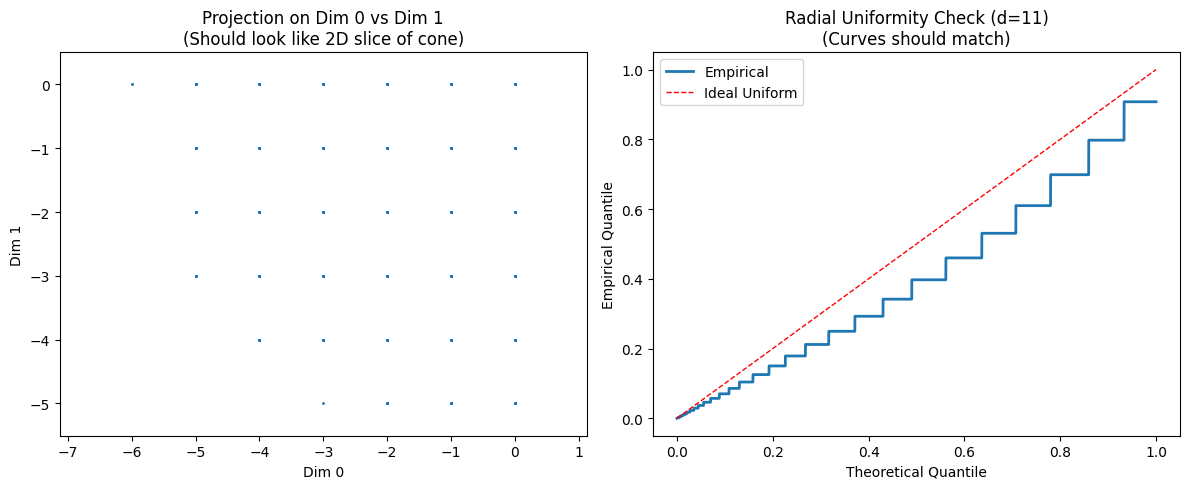

found: 52500 and unique: 52008


In [17]:
sampler2 = CHRRSampler(A, b, R, thinning=5) # Increase thinning if correlation is high
points_chrr, t2 = sampler2.sample(int(np.ceil(fraction * N) * 1.05))
verify_samples(points_chrr, A, b, R)
points_chrr = [tuple(s) for s in points_chrr]
print(f'found: {len(points_chrr)} and unique: {len(set(points_chrr))}')